### Análisis de Clasificación para la predicción si un paciente tiene o no diabetes basado en los datos del data set dado

dataset obtenido de kaggle (https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset)

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

cargamos el data set diabetes.csv

In [158]:
df = pd.read_csv('../data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [159]:
df.shape

(768, 9)

### Exploración de la data

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [161]:
#cantidad relativa de datos nulos en le dataset

df.isna().sum()/df.shape[0]

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64

In [162]:
#eliminacion de datos anomalos o datos nulos que fueron reemplazados por 0
df.drop(df.query('BMI == 0 or BloodPressure == 0').index ,inplace=True)
df.shape

(729, 9)

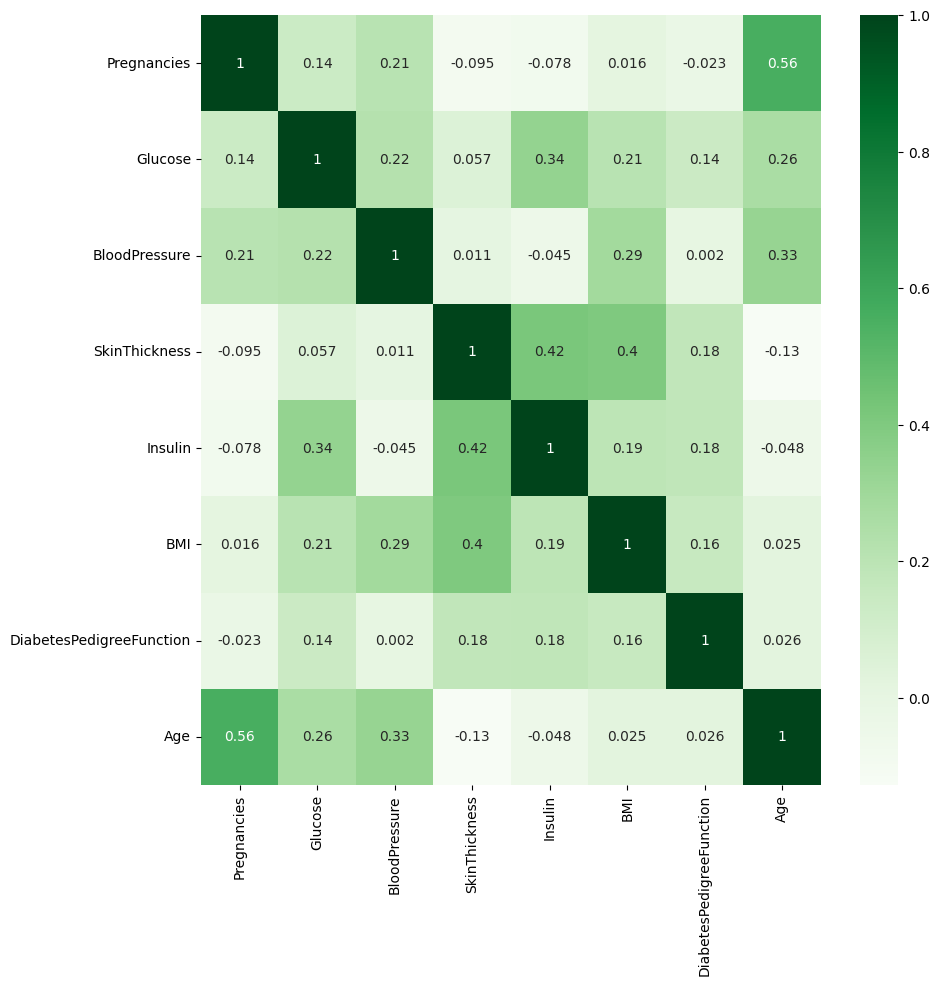

In [163]:
#matriz de correlación
plt.figure(figsize=(10,10))

df_cor = df.drop('Outcome', axis = 1)

corr_mat = df_cor.corr()

sns.heatmap(corr_mat, cmap = 'Greens', annot = True, fmt = '.2g')
plt.show()

<Figure size 2000x2000 with 0 Axes>

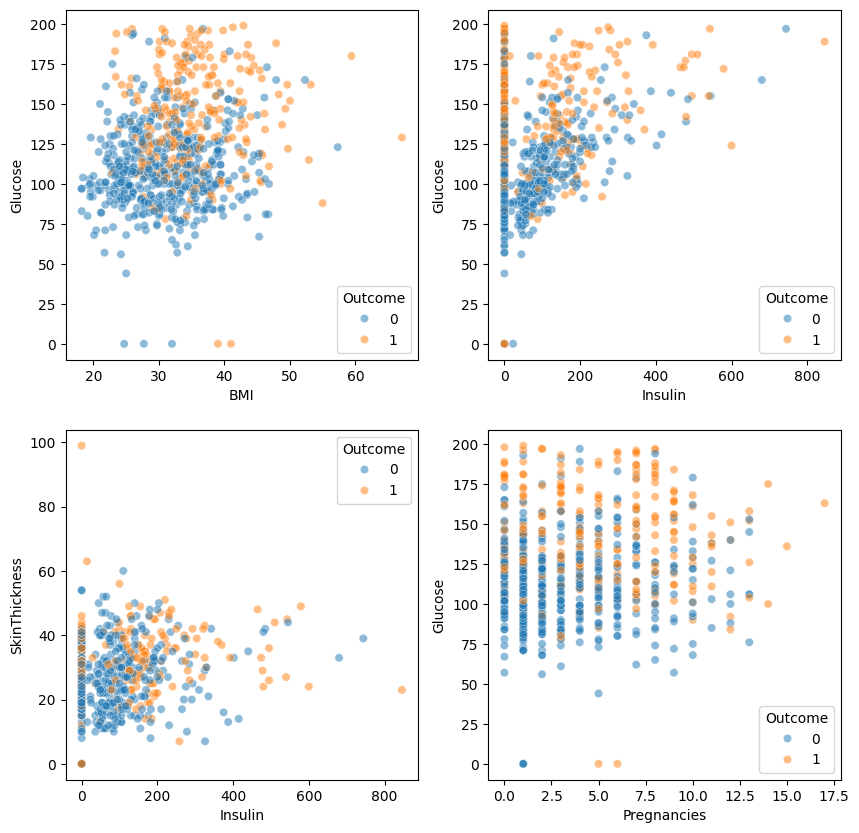

In [164]:
#ilustración de algunos datos correlacionados. Con esto es posible ver qué datos tiene mas impacto en el resultado
plt.figure(figsize=(20,20))
fig, ax = plt.subplots(ncols=2, nrows=2, figsize = (10,10))

sns.scatterplot(x = 'BMI', y = 'Glucose', hue = 'Outcome', data=df, alpha = 0.5, ax = ax[0,0])
sns.scatterplot(x = 'Insulin', y = 'SkinThickness', hue = 'Outcome', data=df, alpha = 0.5, ax = ax[1,0])
sns.scatterplot(x = 'Insulin', y = 'Glucose', hue = 'Outcome', data=df, alpha = 0.5, ax = ax[0,1])
sns.scatterplot(x = 'Pregnancies', y = 'Glucose', hue = 'Outcome', data=df, alpha = 0.5, ax = ax[1,1])
plt.show()

## Creación del modelo

selección de datos para entrenamiento y para probar los modelos 

In [165]:
from sklearn.model_selection import train_test_split

X = df.drop('Outcome', axis = 1)
Y = df.Outcome

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

Árbol de decisión

In [166]:
from sklearn.tree import DecisionTreeClassifier

##creamos el modelo de arbol de decision. Para este modelo elegiremos el criterio entropy

model_DTR = DecisionTreeClassifier(criterion='entropy', random_state=42)
model_DTR.fit(X_train,Y_train)
Y_pred_DTR = model_DTR.predict(X_test)

Random Forest

In [167]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier(criterion='entropy', random_state=42)
model_RF.fit(X_train,Y_train)
Y_pred_RF = model_RF.predict(X_test)

## Evaluación de los modelos

In [168]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

LABELS = ['Healthy', 'Sick']

def mostrar_resultados(y_test,y_pred):
    conf_mat = confusion_matrix(y_test,y_pred)
    plt.figure(figsize = (10,10))
    sns.heatmap(conf_mat, xticklabels=LABELS, yticklabels=LABELS, cmap = 'Greens', annot = True, fmt = 'd')
    plt.ylabel('Verdaderos')
    plt.xlabel('Predicciones')
    plt.show()
    print(classification_report(y_test, y_pred))
    print(f'accuracy score: {accuracy_score(y_test,y_pred)}')

Árbol de decisión

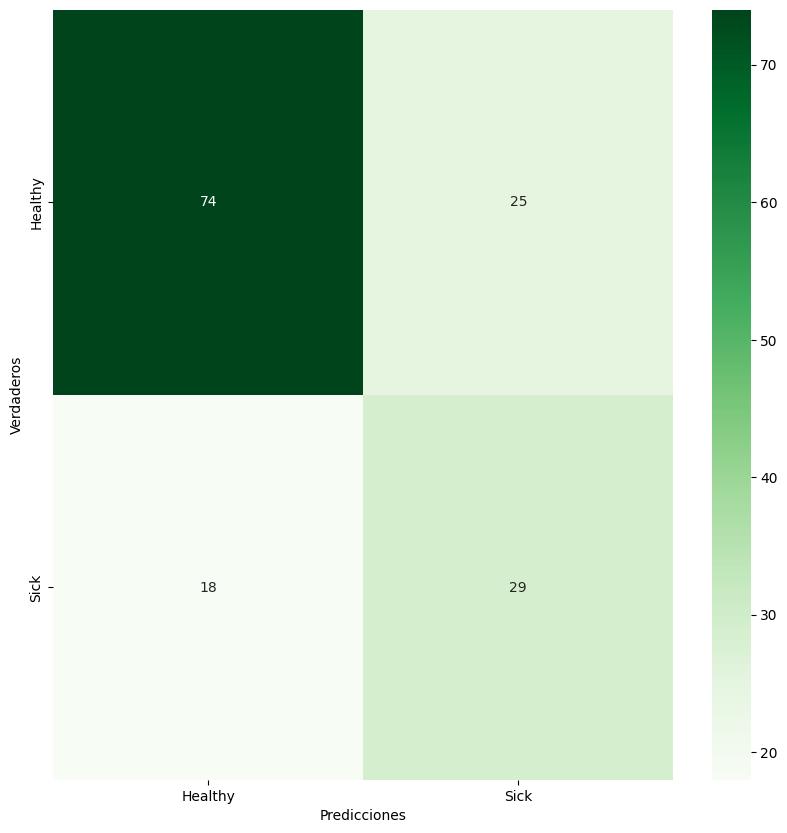

              precision    recall  f1-score   support

           0       0.80      0.75      0.77        99
           1       0.54      0.62      0.57        47

    accuracy                           0.71       146
   macro avg       0.67      0.68      0.67       146
weighted avg       0.72      0.71      0.71       146

accuracy score: 0.7054794520547946


In [169]:
mostrar_resultados(Y_test, Y_pred_DTR)

In [170]:
from sklearn.model_selection import cross_val_score

depths = range(1,10)
performances = []

for depth in depths:
    current_tree = DecisionTreeClassifier(max_depth=depth, criterion='entropy')
    roc_auc = cross_val_score(
        current_tree,
        X,
        Y,
        cv = 5,
        scoring = 'roc_auc'
    ).mean()
    performances.append(roc_auc)

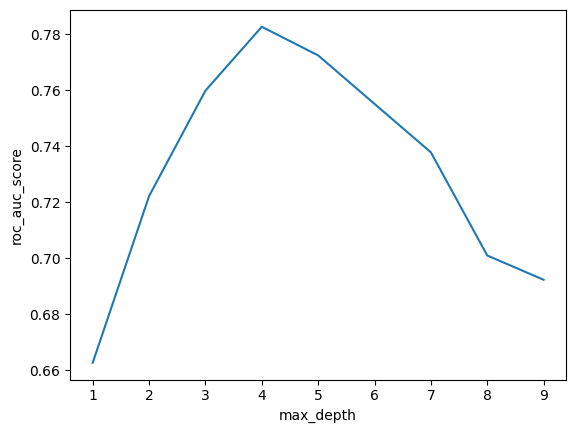

In [171]:
plt.plot(depths, performances)
plt.xlabel('max_depth')
plt.ylabel('roc_auc_score')
plt.show()

In [172]:
## Del grafico anterior se observa que a partir de una profundidad de 4 el rendimiento del modelo disminuye,
## produciendo overfitting. Por lo tanto se vuelve a repetir el modelo

model_DTR_MD4 = DecisionTreeClassifier(max_depth=4, criterion='entropy',random_state=42)

model_DTR_MD4.fit(X_train, Y_train)

Y_pred_DTR_M4 = model_DTR_MD4.predict(X_test)

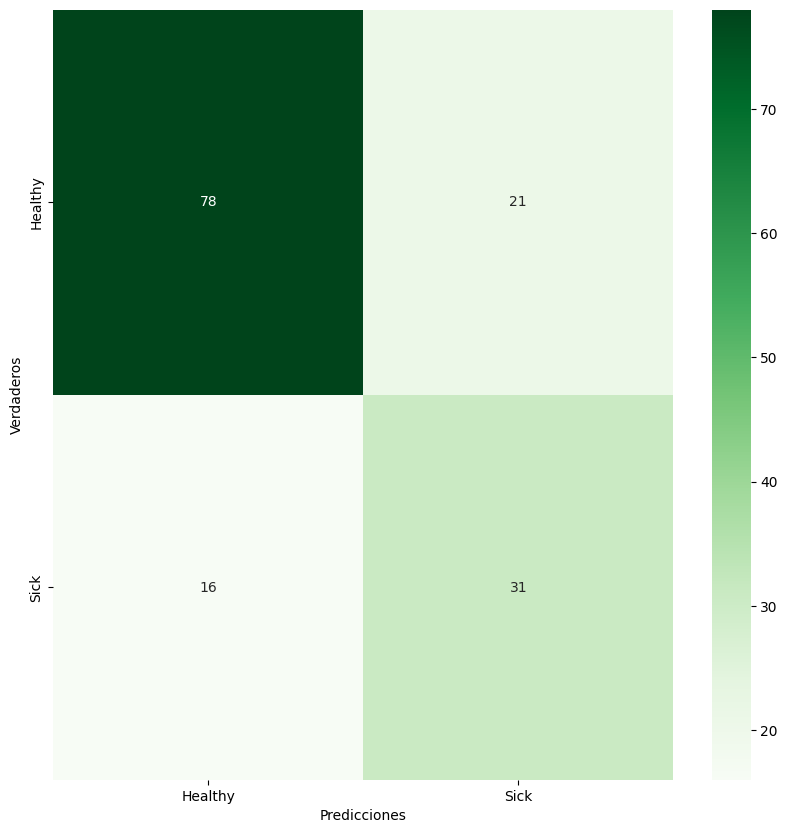

              precision    recall  f1-score   support

           0       0.83      0.79      0.81        99
           1       0.60      0.66      0.63        47

    accuracy                           0.75       146
   macro avg       0.71      0.72      0.72       146
weighted avg       0.75      0.75      0.75       146

accuracy score: 0.7465753424657534


In [173]:
mostrar_resultados(Y_test, Y_pred_DTR_M4)

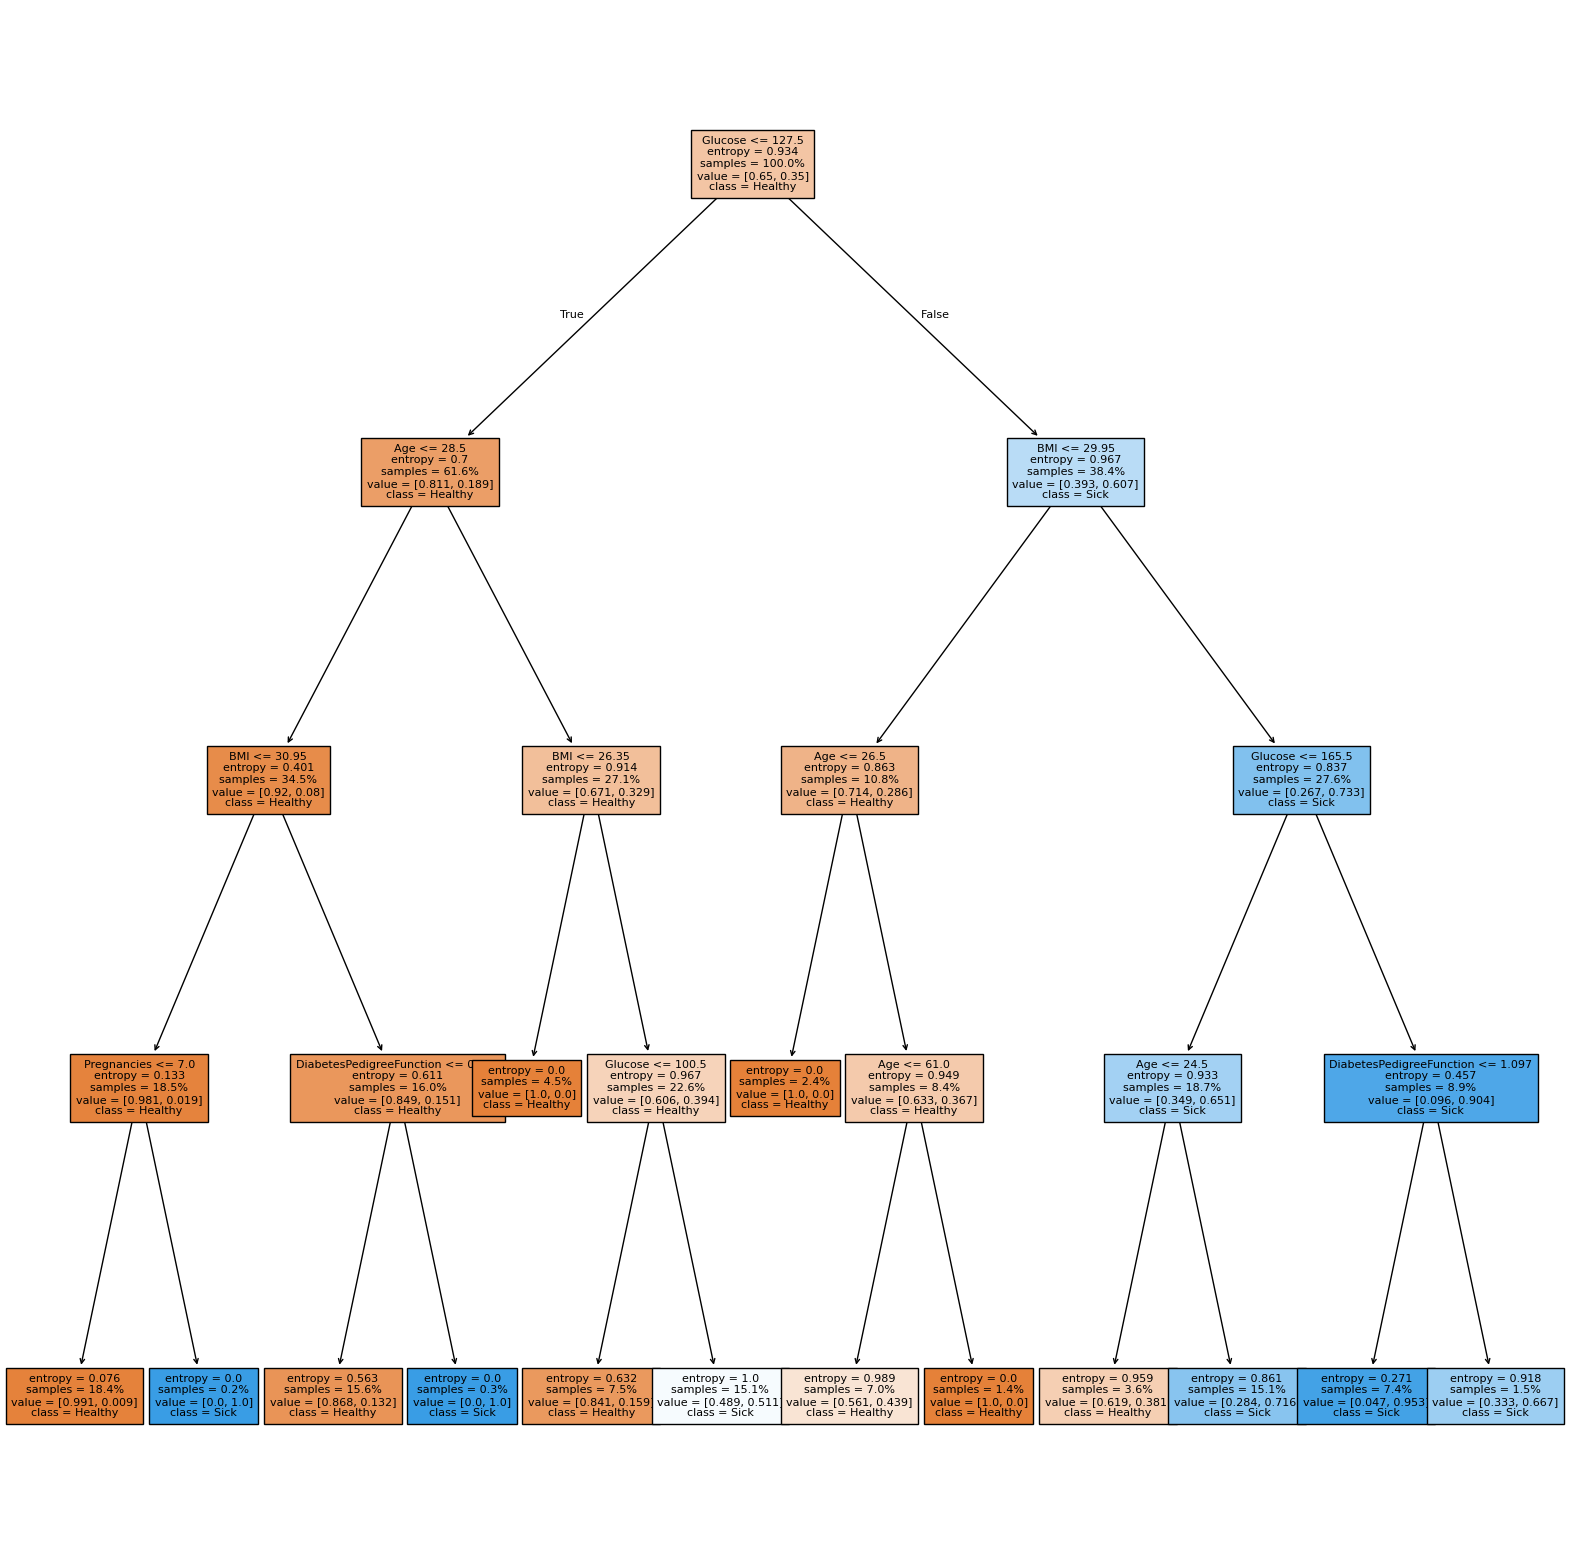

In [174]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,20))

plot_tree(
    model_DTR_MD4,
    feature_names = X.columns,
    class_names=['Healthy','Sick'],
    label= 'all',
    proportion=True,
    filled=True,
    fontsize=8
)
plt.show()

Random Forest

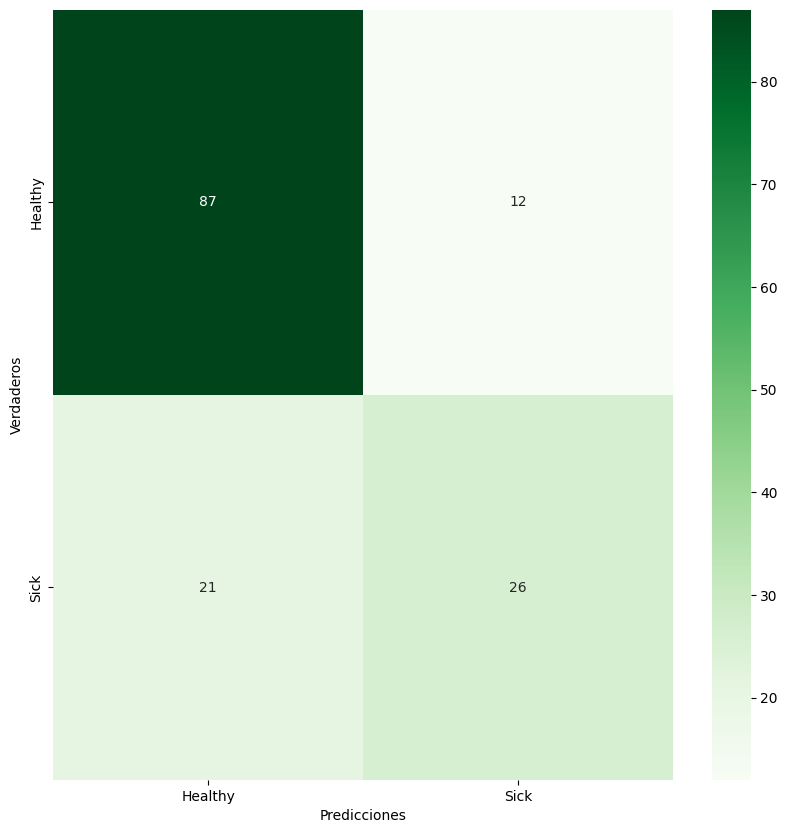

              precision    recall  f1-score   support

           0       0.81      0.88      0.84        99
           1       0.68      0.55      0.61        47

    accuracy                           0.77       146
   macro avg       0.74      0.72      0.73       146
weighted avg       0.77      0.77      0.77       146

accuracy score: 0.773972602739726


In [175]:
mostrar_resultados(Y_test,Y_pred_RF)

In [176]:
max_depths = range(1,10)
performances = []

for depth in depths:
    current_forest = RandomForestClassifier(max_depth=depth, criterion='entropy')
    roc_auc = cross_val_score(
        current_forest,
        X,
        Y,
        cv = 5,
    ).mean()
    performances.append(roc_auc)

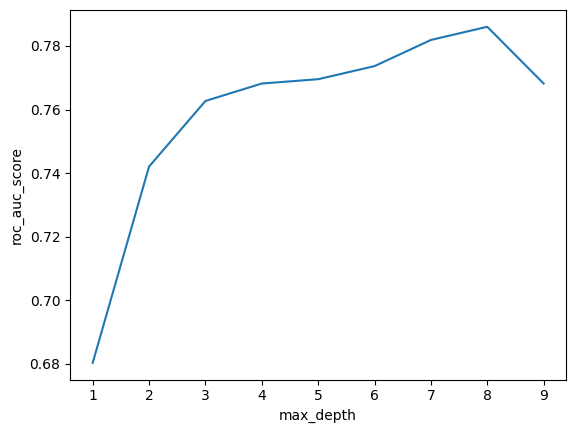

In [177]:
plt.plot(depths, performances)
plt.xlabel('max_depth')
plt.ylabel('roc_auc_score')
plt.show()

In [178]:
## Al igual que en el arbol de decision, se observa que a partir de una profundiad maxima de 8
## el modelo presenta una disminucion en su performance, seguramente produciendo overfitting.
## Luego el nuevo modelo

model_RF_M8 = RandomForestClassifier(max_depth=8, criterion='entropy',random_state=42)
model_RF_M8.fit(X_train, Y_train)
Y_pred_RF_M8 = model_RF_M8.predict(X_test)

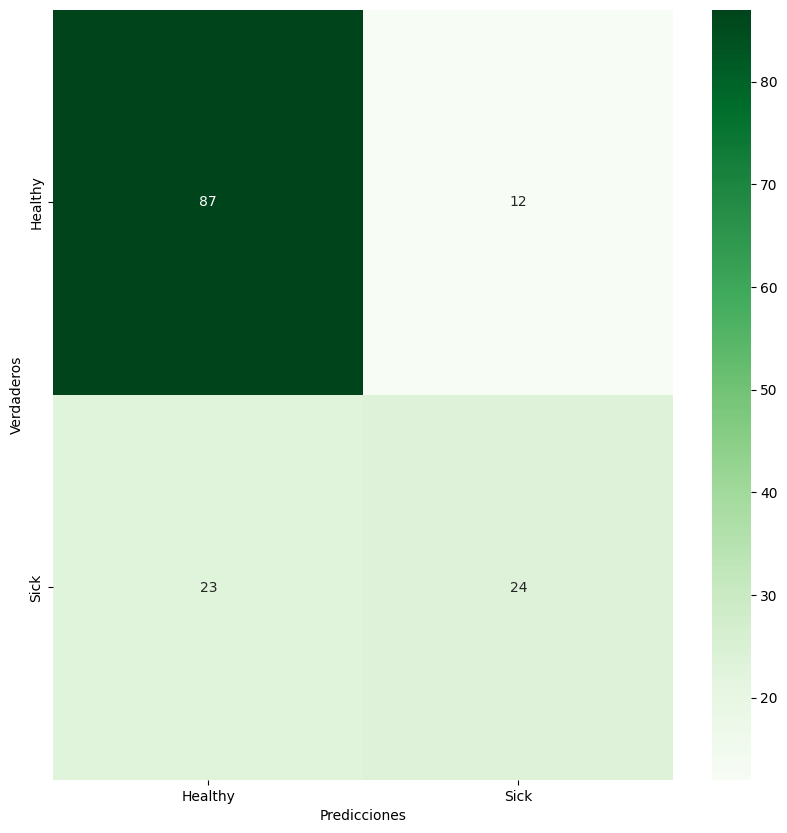

              precision    recall  f1-score   support

           0       0.79      0.88      0.83        99
           1       0.67      0.51      0.58        47

    accuracy                           0.76       146
   macro avg       0.73      0.69      0.71       146
weighted avg       0.75      0.76      0.75       146

accuracy score: 0.7602739726027398


In [179]:
mostrar_resultados(Y_test,Y_pred_RF_M8)

Feature importance para los modelos

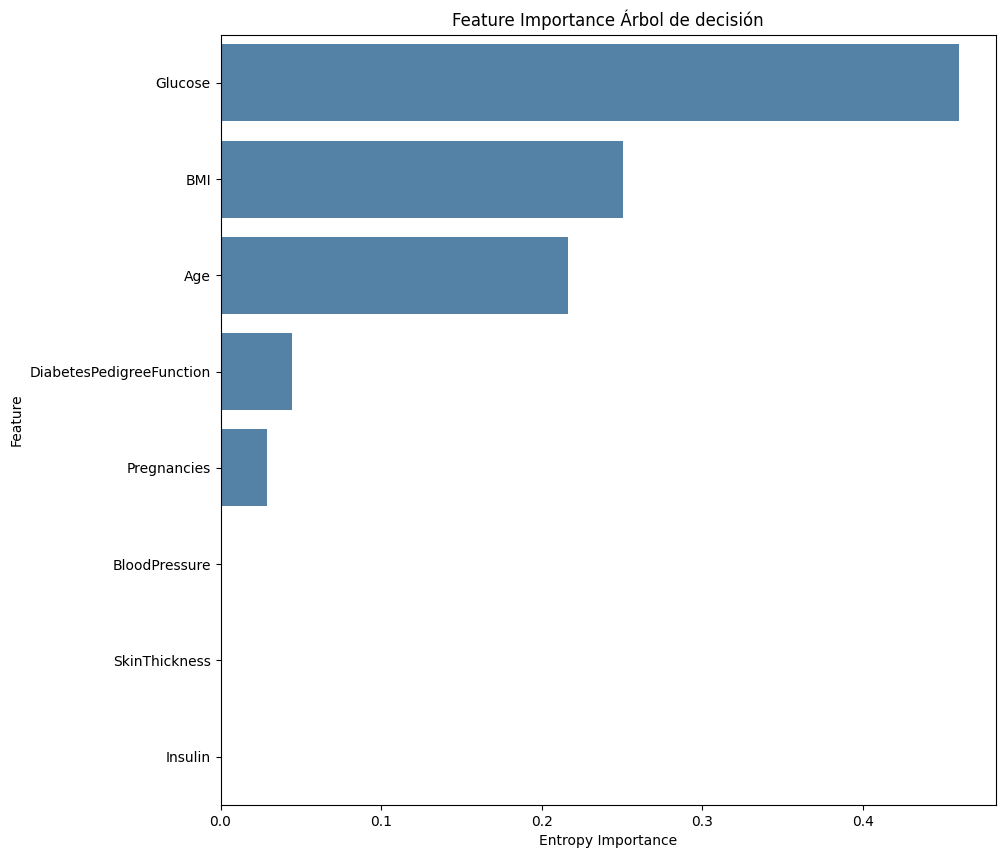

In [183]:
## Arbol de decision
importance_DT = model_DTR_MD4.feature_importances_
features = df.drop('Outcome', axis = 1)
feature_importance_DT = pd.DataFrame({'Feature':features.columns, 'Entropy Importance': importance_DT}).sort_values('Entropy Importance', ascending=False)
plt.figure(figsize = (10,10))
sns.barplot(x = feature_importance_DT['Entropy Importance'], y = feature_importance_DT['Feature'], color = 'steelblue', orient = 'h')
plt.title('Feature Importance Árbol de decisión')
plt.show()

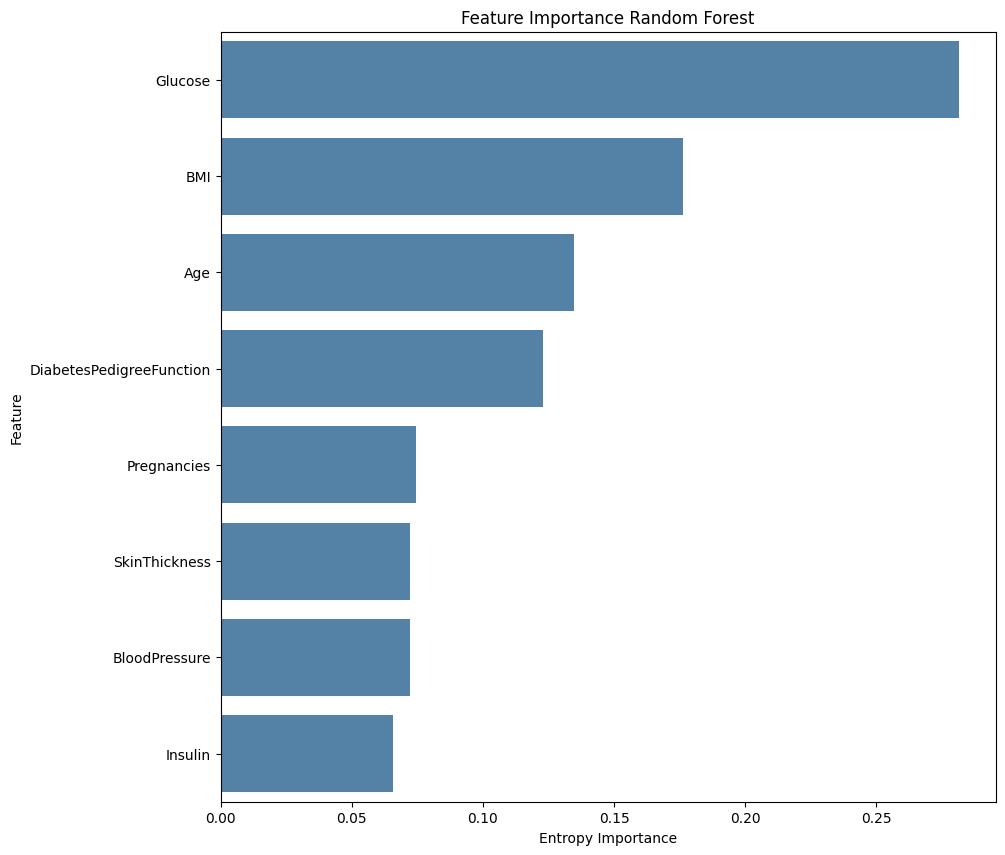

In [184]:
## Random Forest

importance_RF = model_RF_M8.feature_importances_
features = df.drop('Outcome', axis = 1)
feature_importance_RF = pd.DataFrame({'Feature':features.columns, 'Entropy Importance': importance_RF}).sort_values('Entropy Importance', ascending=False)
plt.figure(figsize = (10,10))
sns.barplot(x = feature_importance_RF['Entropy Importance'], y = feature_importance_RF['Feature'], color = 'steelblue', orient = 'h')
plt.title('Feature Importance Random Forest')
plt.show()